In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

Nx = 100
Ny = 100                         #number of samples
dx = 2*1.0e-2 
dy = 2*1.0e-2                               #spatial step 2cm

# ----------------------------------------
# -      physical constants              -
# ---------------------------------------
c    = 3*1.0e8                        #speed of light in vacuum
mu   = 4.0*math.pi*1.0e-7                        #permeability of free space 
e_0  = 1.0/(c**2*mu)                         #permittivity of free space F/m
e_r  = np.ones((Nx,Ny))              #relative permittivity, USE THE RIGHT DATA TYPE!

# ----------------------------------------
# -      temporal information            -
# ----------------------------------------
dt = 1.0/(c*math.sqrt( (1/dx)**2 + (1/dy)**2 ))  #time step (2D CFL-condition)
Nt = 500                                       #number of time steps

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

# ----------------------------------------
# -          source definition           -
# ----------------------------------------
sigma_t = 10*dt                             #width of the pulse
t0      = 3*sigma_t                         #center of the pulse
wavel   = 0.15                              #wavelength [m]
N_lamb  = c/wavel                           #frequency [Hz]


In [3]:
# ------- gaussian pulse ------
# source  = @(t) -2*(t*dt-t0)./sigma_t .* exp(-((t*dt-t0)./sigma_t).^2);                  

# ------- sinusoid ------
source  = lambda t: math.sin(2*math.pi*N_lamb*(t-t0)*dt)

# ------- gaussian modulated sinusoid ------
# source  = @(t) sin(2*pi*N_lamb*(t-t0)*dt).*exp(-((t*dt-t0)./sigma_t).^2);

# ------- logistic modulated sinusoid ------
# source  = @(t) 0.5*(tanh((t-60)/15)+1).*sin(2*pi*N_lamb*(t-t0)*dt);


In [4]:
%run setBackgroundVariables.ipynb
%run makeRoom.ipynb

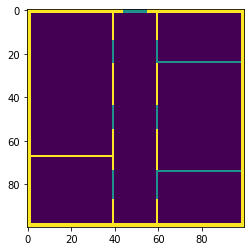

In [5]:
#This is how you make a room
room = np.ones((100,100))
room = makeRoom(room, wall_perm = 3, door_perm = 2)
fig = plt.imshow(room)

#You don't have to do this yourself. This is done in the function call in the block below.

In [6]:
# ----------------------------------------
# -         helper variables             -
# ----------------------------------------
midX   = round(Nx/2)                                   # midpoint in the x-direction
midY   = round(Ny/2)                                   # midpoint in the y-direction
quartX = round(Nx/4)                                   # quarterpoint in the x-direction
quartY = round(Ny/4)                                   # quarterpoint in the y-direction

Cezx1,Cezx2,Cezy1,Cezy2,Chx1,Chx2,Chy1,Chy2,e_r = setBackgroundVariables_I(Nx,Ny,e_r,e_0,mu,dt,dx,dy)

The above sections needs to be performed in order to perform the code sections below. I have performed several simulations each time by changing the position of the source. To give an good idea about the average power over time. I based the measurement on the sanding wave principle. The room is small compared to the speed the signal will propogated through the space. 

With this in mind, we can let the disturbance of the room be performed for a while before starting to measure the maximum value at each position. Because, there will be some interference between direct waves and reflected waves against walls and doors. After a while, we will see the standing wave pattern in the room. In this pattern there will be minimum and maximum values and this will give us a good idea how big the signal will be at each position.
The minimum and maximum values will not move around because this is typicl for astanding wave.

# Which position did you choose for the electric component, and why?

Before making a decision on which position would be the best I have performed several simulations. Some give me a good insight on the wavelength of the signal, others give me a good idea on which can immprove or decrease the wave pattern.

Overall when placing the wifi router in the hall, the signal is more eually spread over the rooms. Off course in the hall it has the highest value. This is also quit simple to see this. But is a position that gives will give a more spreading of the wave before it reflexs on the outer wall. 

In some off the simulations when then source is put in a corner of the space, you can see what if the closest reflected wave is reflected in such a way it immediatly interfered destructive with the source.In that cause the overall radiation is bad. But I we just shift it a bit we can see a more even spread radiatino spectrum. 

This last situation is not as good as the wifi router in the hall but maybe after a carefull placed position of the source. We may become the most even spreaded radiation pattern. 

I just also want to mention that the small room in the left bottom is the hardest one to get a proper signal because it has only one door and is a small room. Because the breaking index of the wall is bigger more signal will be reflected. 

Below you will see a summary of the above statement. I would prefer to place the router in the center of the hall to become an overall higher average value. But there are some other interesting option depending on if it is important to have a good signal in all the different rooms or not. 

If a more equally spreaded radiation is a key element, we could search for an ideal placement of the source in the corner. But then you will need more transmission power to have a signallevel that is the same as if the router is in the middel of the hall. See the second simulation of the bottom row. 

Beacause more power is needed it is not the most interesting one, and in reality the signal strength will decrease will the distance, it is more convenient to put the source in the center of the room. So the distance to the most far off positions are the same. 

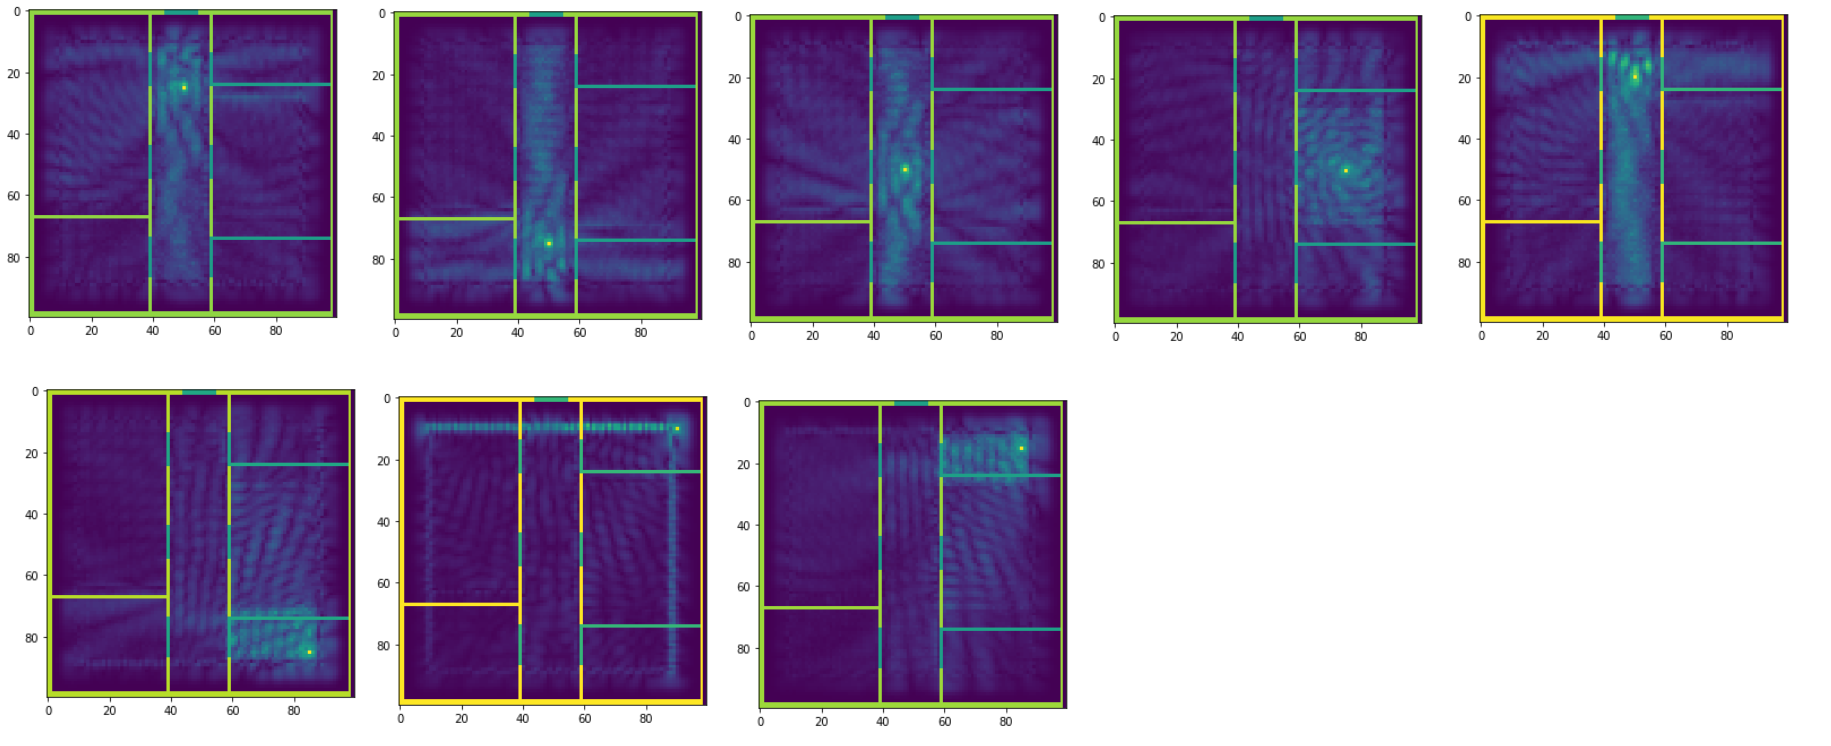

In [11]:
from IPython.display import Image
Image(filename = "Some simulations next to each other.png",width=1000)

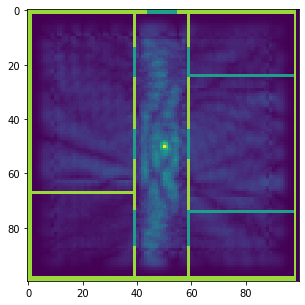

In [9]:
x_disturbance, y_disturbance = midX , midY #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT
    
# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))

for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

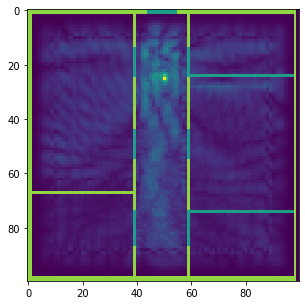

In [10]:
x_disturbance, y_disturbance = midX - quartX , midY #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction


cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT
    
# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))

for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

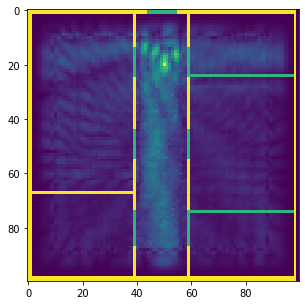

In [7]:
x_disturbance, y_disturbance = midX - quartX - 5 , midY #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction


cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT
    
# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))

for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

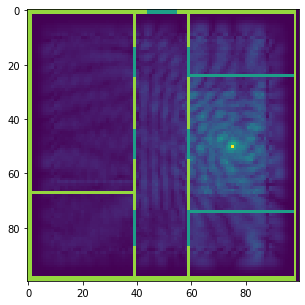

In [6]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = midX , midY + quartY #choose location for disturbance

# for every simulation the fields needs to be reset

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT
    
# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))

for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

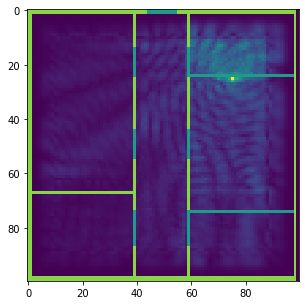

In [7]:
x_disturbance, y_disturbance = midX - quartX , midY + quartY #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT
    
# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))

for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

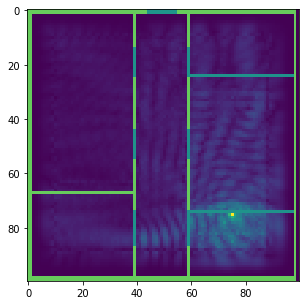

In [8]:
x_disturbance, y_disturbance = midX + quartX , midY + quartY #choose location for disturbance

cMap = []

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 400:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT
    
# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))

for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

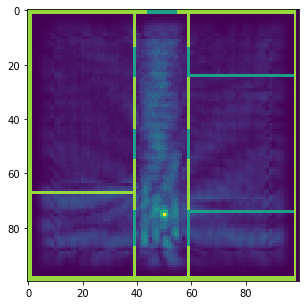

In [11]:
x_disturbance, y_disturbance = midX + quartX , midY  #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))

for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

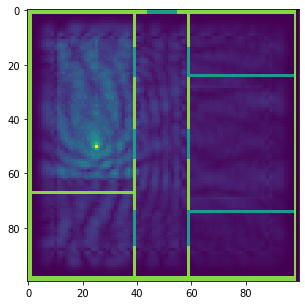

In [12]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = midX , midY - quartY #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT
    
# This is to make it a clean drawing with room definition intact    
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))

for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

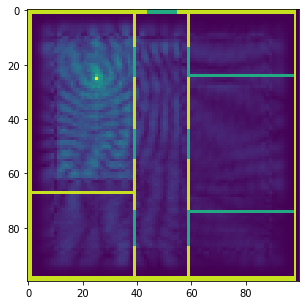

In [13]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = midX - quartX , midY - quartY #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT
    
# This is to make it a clean drawing with room definition intact    
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))

for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

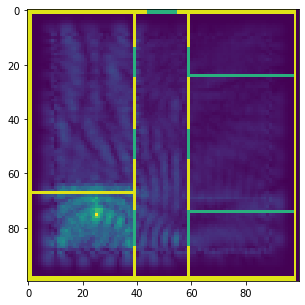

In [14]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = midX + quartX , midY - quartY #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))
for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

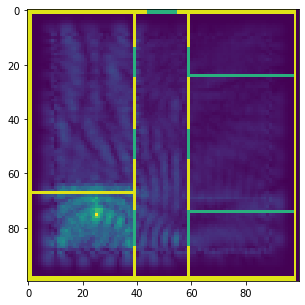

In [15]:
##### display.clear_output(wait=True)
result = np.zeros((Nx,Ny))

for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)


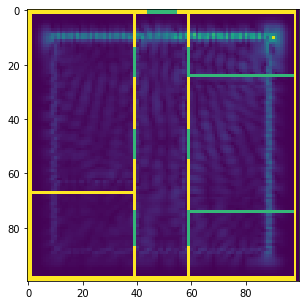

In [16]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = 10 , 90 #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))
for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

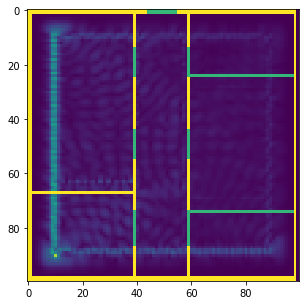

In [17]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = 90 , 10 #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))
for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

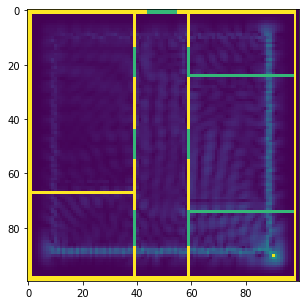

In [18]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = 90 , 90 #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))
for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

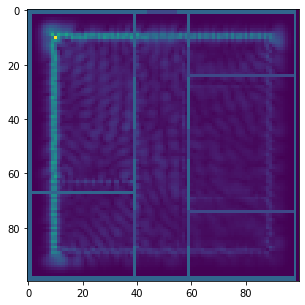

In [8]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = 10 , 10 #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))
for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

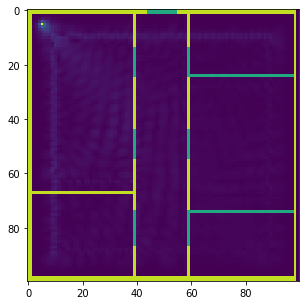

In [32]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = 5 , 5 #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))
for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

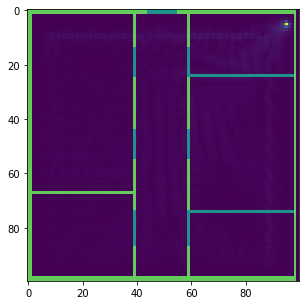

In [21]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = 5 , 95 #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))
for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

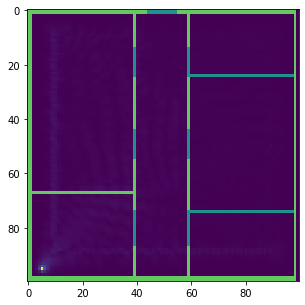

In [22]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = 95, 5 #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))
for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

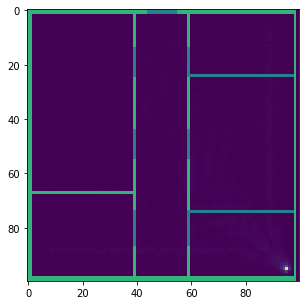

In [23]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = 95 , 95 #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))
for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

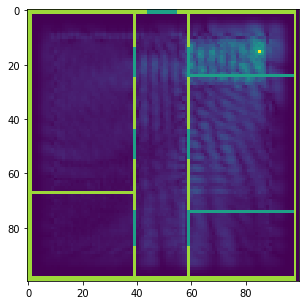

In [24]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = 15 , 85 #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))
for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

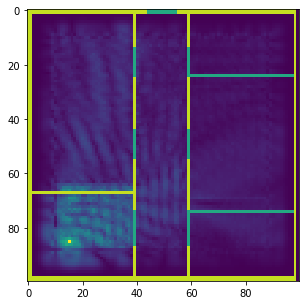

In [25]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = 85 , 15 #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))
for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

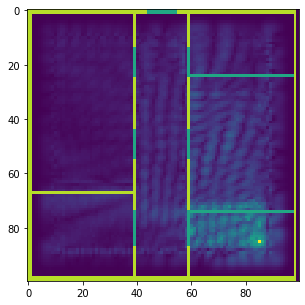

In [26]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = 85 , 85 #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))
for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

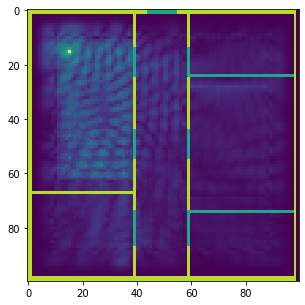

In [27]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = 15 , 15 #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))
for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

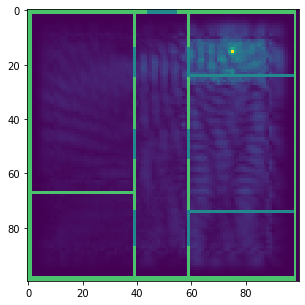

In [28]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = 15 , 75 #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))
for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)

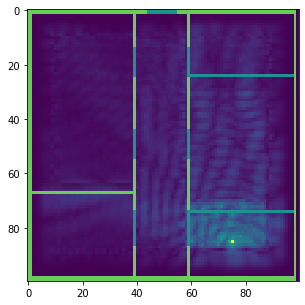

In [29]:
from matplotlib.colors import LinearSegmentedColormap

x_disturbance, y_disturbance = 85 , 75 #choose location for disturbance

# ----------------------------------------
# -      field variable allocation       -
# ----------------------------------------
Hx = np.zeros((Nx,Ny))                        #magnetic field x-component
Hy = np.zeros((Nx,Ny))                           #magnetic field y-component
Ez = np.zeros((Nx,Ny))                            #electric field z-component
Ezx = np.zeros((Nx,Ny))                           #electric field z-component in the x-direction
Ezy = np.zeros((Nx,Ny))                        #electric field z-component in the y-direction

cMap = []
for value, colour in zip([0, 1],["Yellow", "Black"]):
    cMap.append((value, colour))
# ----- array for storing the maximum value of the field at a certain spot after stabilitsation of the radiation pattern
Ez_max = np.zeros((Nx,Ny))
#------ iterate from t=0 until t=Nt-1 (or iterate Nt times) ------ 
for t in range(Nt):
    
    #------ solve dtEzx = dxHy ------ 
    for iX in range(1, Nx):
        for iY in range(Ny):
            Ezx[iY,iX] = Cezx1[iY,iX]*Ezx[iY,iX ]+ Cezx2[iY,iX]*( (Hy[iY,iX]-Hy[iY,iX-1]) )

    #------ solve dtEzy = - dyHx ------     
    for iX in range(Nx):
        for iY in range(1, Ny):
            Ezy[iY,iX] = Cezy1[iY,iX]*Ezy[iY,iX ]+ Cezy2[iY,iX]*(-(Hx[iY,iX]-Hx[iY-1,iX]) ) #implement analogously to the above loop, but change to relevant parts
    
    #------ recouple Ez ------
    Ez = Ezx+Ezy 
    
    #------ add source to the electric field ------ 
    Ez[x_disturbance, y_disturbance] = Ez[x_disturbance, y_disturbance] + source(t)
    
    #------ solve dtHx = -dyEz ------ 
    for iX in range(Nx):
        for iY in range(Ny-1):
            Hx[iY,iX] = Chx1[iY,iX]*Hx[iY,iX] - Chx2[iY,iX]*( Ez[iY+1,iX] - Ez[iY,iX] )

    
    #------ solve dtHy = dxEz ------ 
    for iX in range(Nx-1):
        for iY in range(Ny):
            Hy[iY,iX] = Chy1[iY,iX]*Hy[iY,iX] + Chy2[iY,iX]*( Ez[iY,iX+1] - Ez[iY,iX] ) #implement analogously to the above loop, but change to relevant parts
    
#     display.clear_output(wait=True)
#     plt.figure(figsize=(5,5))
#     fig = plt.imshow(Ez+room)
    
#     plt.pause(0.0000001)
    
    if t> 300:
         for iX in range(Nx-1):
            for iY in range(Ny):
                if Ez_max[iY,iX] < abs(Ez[iY,iX]):
                    Ez_max[iY,iX]= abs(Ez[iY,iX])
    #SHOW PLOT HERE
    #PAUSE PLOT
    #CLEAR OUTPUT

# This is to make it a clean drawing with room definition intact
display.clear_output(wait=True)
result = np.zeros((Nx,Ny))
for iX in range(Nx-1):
            for iY in range(Ny):
                if room[iY,iX] > 1:
                    result[iY,iX]= room[iY,iX]
                else:
                    result[iY,iX]= 10*Ez_max[iY,iX]
                    


plt.figure(figsize=(5,5))
fig = plt.imshow(result)
    
plt.pause(0.0000001)